# Implementing the paper -- Our Baseline

## 1.1 - Loading Image Paths

In [5]:
import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb

import torch
from torch import nn, optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

paths = glob.glob("datasets/test2017/*.jpg") # COCO 데이터셋의 이미지들
np.random.seed(123) # Seeding for reproducible results
paths_subset = np.random.choice(paths, 10000, replace=False) # 무작위 10,000개의 이미지를 선택
rand_idxs = np.random.permutation(10000) # 선택한 이미지들의 인덱스를 섞는다
train_idxs = rand_idxs[:8000] # 80%는 학습 데이터로 사용
val_idxs = rand_idxs[8000:] # 20%는 검증 데이터로 사용
train_paths = paths_subset[train_idxs]
val_paths = paths_subset[val_idxs]
print(len(train_paths), len(val_paths))

8000 2000


## 1.2 = Making Datasets and DataLoaders

In [6]:
from colorization_dataset import ColorizationDataset

# SIZE = 256
# class ColorizationDataset(Dataset):
#     def __init__(self, paths, split='train'):
#         if split == 'train':
#             self.transforms = transforms.Compose([
#                 transforms.Resize((SIZE, SIZE),  Image.BICUBIC),
#                 transforms.RandomHorizontalFlip(), # A little data augmentation!
#             ])
#         elif split == 'val':
#             self.transforms = transforms.Resize((SIZE, SIZE),  Image.BICUBIC)
#
#         self.split = split
#         self.size = SIZE
#         self.paths = paths
#
#     def __getitem__(self, idx):
#         img = Image.open(self.paths[idx]).convert("RGB")
#         img = self.transforms(img)
#         img = np.array(img)
#         img_lab = rgb2lab(img).astype("float32") # Converting RGB to L*a*b
#         img_lab = transforms.ToTensor()(img_lab)
#         L = img_lab[[0], ...] / 50. - 1. # Between -1 and 1
#         ab = img_lab[[1, 2], ...] / 110. # Between -1 and 1
#
#         return {'L': L, 'ab': ab}
#
#     def __len__(self):
#         return len(self.paths)

In [7]:
def make_dataloaders(batch_size=16, n_workers=4, pin_memory=True, **kwargs):  # 데이터로더를 생성하는 함수
    dataset = ColorizationDataset(**kwargs) # 주어진 매개변수를 이용해 데이터셋을 생성한다.
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=n_workers,
                            pin_memory=pin_memory) # 생성한 데이터셋으로 데이터로더를 생성한다.
    return dataloader

train_dl = make_dataloaders(paths=train_paths, split='train') # 학습 데이터셋에 대한 데이터로더
val_dl = make_dataloaders(paths=val_paths, split='val') # 검증 데이터셋에 대한 데이터로더

data = next(iter(train_dl)) # 첫 번째 미니배치
Ls, abs_ = data['L'], data['ab'] # LAB 이미지의 L과 AB
print(Ls.shape, abs_.shape)
print(len(train_dl), len(val_dl))

torch.Size([16, 1, 256, 256]) torch.Size([16, 2, 256, 256])
500 125


## 1.3 - Generator proposed by the paper

In [8]:
# U-Net 구조에서 사용되는 각 블록을 정의하는 클래스
class UnetBlock(nn.Module):
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False,
                 innermost=False, outermost=False):
        super().__init__()
        self.outermost = outermost

        # 입력 채널이 지정되지 않았다면 출력 채널(nf)를 사용
        if input_c is None: input_c = nf

        # 다운샘플링을 위한 Convolution 정의
        downconv = nn.Conv2d(input_c, ni, kernel_size=4,
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(nf)

        # outermost일 때는 업샘플링 후 Tanh 활성화 함수를 사용
        if outermost:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up

        # innermost일 때는 업샘플링 후 BatchNorm 사용
        elif innermost:
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up

        # 그 외의 경우에는 업샘플링 후 BatchNorm 및 Dropout(optional) 사용
        else:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]

            # dropuot인 경우 Dropout 레이어 추가
            if dropout: up += [nn.Dropout(0.5)]
            model = down + [submodule] + up

        # Sequential을 사용ㅇ하여 레이어를 순차적으로 적용
        self.model = nn.Sequential(*model)

    def forward(self, x):
        # outermost일 때는 모델 전체를 반환
        if self.outermost:
            return self.model(x)
        # 그 외에는 입력과 모델의 결과를 채널 방향으로 결합하여 반환
        else:
            return torch.cat([x, self.model(x)], 1)

# U-Net 아키텍쳐를 정의하는 클래스
class Unet(nn.Module):
    def __init__(self, input_c=1, output_c=2, n_down=8, num_filters=64):
        super().__init__()

        # innermost 레이어를 만들기 위해 UnetBlock 클래스를 사용
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)

        # n_down - 5 만큼의 다운샘플링 레이어를 생성
        for _ in range(n_down - 5):
            unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)
        out_filters = num_filters * 8

        # 3개의 업샘플링 레이어를 생성
        for _ in range(3):
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block)
            out_filters //= 2

        # outermost 레이어를 생성하여 전체 U-Net 아키텍쳐 생성
        self.model = UnetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True)

    def forward(self, x):
        return self.model(x)

## 1.4 - Discriminator

In [9]:
# PatchGan Discriminator를 정의하는 클래스
class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()

        model = [self.get_layers(input_c, num_filters, norm=False)] # Discriminator 모델을 정의하기 위한 리스트

        # 다운샘플링 레이어를 추가
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2)
                          for i in range(n_down)]
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)] # 마지막 레이어 추가 (Normalization 및 Activation을 사용하지 않음)

        self.model = nn.Sequential(*model) # Sequential을 이용하여 Discriminator 모델 정의

    # Discriminator에서 사용되는 Convolutional 레이어를 생성하는 메서드
    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True):
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)] # Convolutional 레이어 추가
        if norm: layers += [nn.BatchNorm2d(nf)] # Batch Normalization 레이어 추가
        if act: layers += [nn.LeakyReLU(0.2, True)] # Leaky ReLU Activation 레이어 추가
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [20]:
print(PatchDiscriminator(input_c=3))

PatchDiscriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (

In [10]:
discriminator = PatchDiscriminator(3) # PatchGAN Discriminator 인스턴스 생성
dummy_input = torch.randn(16, 3, 256, 256) # batch_size, channels, size, size (더미 입력 데이터 샘플 16개, 채널 3개, 256x256 크기)
out = discriminator(dummy_input) # 모델에 더미 입력을 전달하여 출력 계산
out.shape

torch.Size([16, 1, 30, 30])

## 1.5 - GAN Loss

In [11]:
# GAN loss을 정의하는 클래스
class GANLoss(nn.Module):
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super().__init__()

        # 실제 및 가짜 레이블을 버퍼로 등록
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))

        # GAN 모드에 따라 loss 함수 선택
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss() # 이진 교차 엔트로피 loss
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss() # 평균 제곱 오차 loss

    # 실제 또는 가짜 레이블을 반환하는 메서드
    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)

    # GAN loss을 계산하여 반환하는 메서드
    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

## 1.6 - Model Initialization

In [12]:
def init_weights(net, init='norm', gain=0.02):

    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')

            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)

    net.apply(init_func)
    print(f"model initialized with {init} initialization")
    return net

def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model

## 1.7 - Putting everything together

In [13]:
class MainModel(nn.Module):
    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4,
                 beta1=0.5, beta2=0.999, lambda_L1=100.):
        """
        :param net_G:
        :param lr_G: Generator의 학습률
        :param lr_D: Discriminator의 학습률
        :param beta1: Adam 옵티마이저의 첛 번째 모멘텀
        :param beta2: Adam 옵티마이저의 두 번째 모멘텀
        :param lambda_L1: L1 loss 가중치
        """
        super().__init__()

        # macOS M1 프로세스를 사용할 때 GPU를 쓰기 위한 코드
        self.device = torch.device("mps:0" if torch.backends.mps.is_available() else "cpu")

        # lambda_L1은 L1 loss 가중치
        self.lambda_L1 = lambda_L1

        # Generator 및 Discriminator 모델 초기화
        if net_G is None:
            self.net_G = init_model(Unet(input_c=1, output_c=2, n_down=8, num_filters=64), self.device)
        else:
            self.net_G = net_G.to(self.device)

        self.net_D = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), self.device)

        # GAN 및 L1 loss 함수 초기화
        self.GANcriterion = GANLoss(gan_mode='vanilla').to(self.device)
        self.L1criterion = nn.L1Loss()

        # Generator 및 Discriminator의 최적화를 위한 Adam 옵티마이저 초기화
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))

    # 모델의 파라미터에 대해 requires_grad를 설정하는 메서드
    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad

    # 입력 데이터를 설정하는 메서드
    def setup_input(self, data):
        self.L = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)

    def forward(self):
        self.fake_color = self.net_G(self.L)

    # Discriminator를 역전파하여 loss 계산하는 메서드
    def backward_D(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()

    # Generator를 역전파하여 GAN 및 L1 loss 계산하는 메서드
    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()

    # 최적화를 수행하는 메서드
    def optimize(self):
        self.forward()

        # Discriminator 업데이트
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()

        # Generator 업데이트
        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()

model = MainModel()

model initialized with norm initialization
model initialized with norm initialization


## 1.8 - Utility functions

In [14]:
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3

    def update(self, val, count=1):
        # 주어진 값(val)과 개수(count)를 사용하여 미터로 업데이트하는 메서드
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
    """
    여러 loss을 기록하기 위한 AverageMeter 객체들을 생성하는 함수
    :return: 각 loss 유형에 대한 AverageMeter 객체를 생성하고 이들을 딕셔너리로 반환
    """

    loss_D_fake = AverageMeter() # 가짜 데이터에 대한 Discriminator loss
    loss_D_real = AverageMeter() # 진짜 데이터에 대한 Discriminator loss
    loss_D = AverageMeter() # 전체 Discriminator loss
    loss_G_GAN = AverageMeter() # Generator GAN loss
    loss_G_L1 = AverageMeter() # Generator L1 loss
    loss_G = AverageMeter() # 전체 Generator loss

    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

def update_losses(model, loss_meter_dict, count):
    # 모델의 loss 값을 받아와서 각 loss 유형에 해당하는 AverageMeter를 업데이트 하는 함수
    # 주어진 모델에서 각 loss 유형에 대한 loss 값을 가져와서 AverageMeter를 업데이트
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name) # 모델에서 해당 loss 유형에 대한 loss 값을 가져옴
        loss_meter.update(loss.item(), count=count) # AverageMeter 업데이트 (count는 배치 크기)

def lab_to_rgb(L, ab):
    """
    LAB에서 RGB로 변환하는 함수
    :param L: L 채널(명도) 정보를 포함하는 Tensor
    :param ab: ab 채널(색상) 정보를 포함하는 Tensor
    :return: RGB 이미지로 변환된 Numpy 배열
    """

    # L, AB 채널을 원래 범위로 되돌리고 Tensor를 Numpy 배열로 반환
    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy() # GPU <-> CPU 변경????????????????

    # 각 이미지에 대해서 LAB에서 RGB로 변경
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0) # Numpy 배열로 스택하여 반환

def visualize(model, data, save=True):
    """
    모델의 출력을 시각화하는 함수
    :param model: 시각화할 모델
    :param data: 시각화할 데이터
    :param save: 이미지를 저장할지 여부를 결정하는 플래그
    :return:
    """
    # Generator 네트워크를 평가 모드로 설정하고, 입력 데이터를 이용
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()

    # 생성된 가짜 컬러 이미지와 실제 컬러 이미지를 가져옴
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L

    # LAB에서 RGB로 이미지 변환
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)

    fig = plt.figure(figsize=(15, 8)) # 시각화를 위한 Matplotlib 플롯 설정

    # 첫 5개의 샘플에 대해 각각 원본 L 채널, 생성된 컬러 이미지, 실제 컬러 이미지를 플롯
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray') # 원본 L 채널
        ax.axis("off")

        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i]) # 생성된 컬러 이미지
        ax.axis("off")

        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i]) # 실제 컬러 이미지
        ax.axis("off")
    plt.show()

    if save: # save 플래그가 True인 경우 이미지를 파일로 저장
        fig.savefig(f"colorization_{time.time()}.png")

def log_results(loss_meter_dict): # 로그
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")

## 1.9 - Training function

In [ ]:
def train_model(model, train_dl, epochs, display_every=200):
    data = next(iter(val_dl)) # Validation 데이터로부터 시각화용 배치를 얻음

    for e in range(epochs):
        loss_meter_dict = create_loss_meters() # loss을 기록하기 위한 미터 객체들을 초기화
        i = 0 # 반복 횟수
        for data in tqdm(train_dl): # 훈련 데이터 로더에서 미니배치를 순회
            model.setup_input(data) # 모델 입력 데이터 설정
            model.optimize() # 모델 최적화
            update_losses(model, loss_meter_dict, count=data['L'].size(0)) # loss 업데이트
            i += 1
            if i % display_every == 0: # 주어진 주기마다 loss과 모델 출력을 표시
                print(f"\nEpoch {e+1}/{epochs}")
                print(f"Iteration {i}/{len(train_dl)}")
                log_results(loss_meter_dict) # 현재까지의 loss을 출력
                visualize(model, data, save=False) # 모델의 출력을 시각화

train_model(model, train_dl, 100) # 모델 훈련 함수 호출

In [ ]:
torch.save(model.state_dict(), 'trained_model.pth')

#

model initialized with norm initialization
model initialized with norm initialization


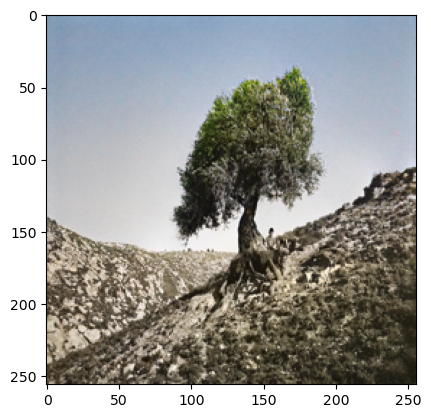

In [39]:
import PIL

model = MainModel()

# Apple M1
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# device = torch.device("cpu")
model.load_state_dict(
    torch.load(
        "trained_model.pth",
        map_location=device
    )
)
path = "images/tree1_blackwhite.jpg"
img = PIL.Image.open(path)
img = img.resize((256, 256))
# to make it between -1 and 1
img = transforms.ToTensor()(img)[:1] * 2. - 1.
model.eval()
with torch.no_grad():
    preds = model.net_G(img.unsqueeze(0).to(device))
colorized = lab_to_rgb(img.unsqueeze(0), preds.cpu())[0]
plt.imshow(colorized)